In [1]:
# This chunk of code is from the "functions.py" of paper "Agent-based model calibration using machine learning surrogates"
""" Ignore Warnings """
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

""" Imports """
import numpy as np
import pandas as pd
import sobol_seq
from scipy.stats.distributions import entropy
import matplotlib.pylab as plt
import seaborn as sns
import numba

""" surrogate models """
# Xtreeme Gradient Boosted Decision Trees
from xgboost import XGBRegressor, XGBClassifier

# Gaussian Process Regression (Kriging)
# modified version of kriging to make a fair comparison with regard
# to the number of hyperparameter evaluations
from sklearn.gaussian_process import GaussianProcessRegressor


""" cross-validation
Cross validation is used in each of the rounds to approximate the selected 
surrogate model over the data samples that are available. 

The evaluated parameter combinations are randomly split into two sets. An 
in-sample set and an out-of-sample set. The surrogate is trained and its 
parameters are tuned to an in-sample set, while the out-of-sample performance 
is measured (using a selected performance metric) on the out-of-sample set. 
This out-of-sample performance is then used as a proxy for the performance 
on the full space of unevaluated parameter combinations. In the case of the 
proposed procedure, this full space is approximated by the randomly selected 
pool.
"""
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold
from skopt import gp_minimize

""" performance metric """
# Mean Squared Error
from sklearn.metrics import mean_squared_error, f1_score

""" Defaults Algorithm Tuning Constants """
_N_EVALS = 10
_N_SPLITS = 5
_CALIBRATION_THRESHOLD = 1.00

""" Functions """

numba.jit()
def set_surrogate_as_gbt():
    """ Set the surrogate model as Gradient Boosted Decision Trees
    Helper function to set the surrogate model and parameter space
    as Gradient Boosted Decision Trees.

    For detail, see:
    http://scikit-learn.org/stable/modules/generated/
    sklearn.ensemble.GradientBoostingRegressor.html


    Parameters
    ----------

    None

    Returns
    -------

    surrogate_model :

    surrogate_parameter_space :


    """

    surrogate_model = XGBRegressor(seed=0)

    surrogate_parameter_space = [
        (100, 1000),  # n_estimators
        (0.01, 1),  # learning_rate
        (10, 1000),  # max_depth
        (0.0, 1),  # reg_alpha
        (0.0, 1),  # reg_lambda
        (0.25, 1.0)]  # subsample

    return surrogate_model, surrogate_parameter_space

numba.jit()
def custom_metric_regression(y_hat, y):
    return 'MSE', mean_squared_error(y.get_label(), y_hat)

numba.jit()
def custom_metric_binary(y_hat, y):
    return 'MSE', f1_score(y.get_label(), y_hat, average='weighted')

numba.jit()
def fit_surrogate_model(X, y):
    """ Fit a surrogate model to the X,y parameter combinations

    Parameters
    ----------

    surrogate_model :

    X :

    y :


    Output
    ------
    surrogate_model_fitted : A surrogate model fitted

    """
    surrogate_model, surrogate_parameter_space = set_surrogate_as_gbt()

    def objective(params):
        n_estimators, learning_rate, max_depth, reg_alpha, \
        reg_lambda, subsample = params

        reg = XGBRegressor(n_estimators=n_estimators,
                           learning_rate=learning_rate,
                           max_depth=max_depth,
                           reg_alpha=reg_alpha,
                           reg_lambda=reg_lambda,
                           subsample=subsample,
                           seed=0)

        kf = KFold(n_splits=_N_SPLITS, random_state=0, shuffle=True)
        kf_cv = [(train, test) for train, test in kf.split(X, y)]

        return -np.mean(cross_val_score(reg,
                                        X, y,
                                        cv=kf_cv,
                                        n_jobs=1,
                                        fit_params={'eval_metric': custom_metric_regression},
                                        scoring="neg_mean_squared_error"))

    # use Gradient Boosted Regression to optimize the Hyper-Parameters.
    surrogate_model_tuned = gp_minimize(objective,
                                        surrogate_parameter_space,
                                        n_calls=_N_EVALS,
                                        acq_func='gp_hedge',
                                        n_jobs=-1,
                                        random_state=0, verbose=9)

    surrogate_model.set_params(n_estimators=surrogate_model_tuned.x[0],
                               learning_rate=surrogate_model_tuned.x[1],
                               max_depth=surrogate_model_tuned.x[2],
                               reg_alpha=surrogate_model_tuned.x[3],
                               reg_lambda=surrogate_model_tuned.x[4],
                               subsample=surrogate_model_tuned.x[5],
                               seed=0)

    surrogate_model.fit(X, y, eval_metric=custom_metric_regression)

    return surrogate_model

numba.jit()
def get_sobol_samples(n_dimensions, samples, parameter_support):
    """


    """
    # Get the range for the support
    support_range = parameter_support[:, 1] - parameter_support[:, 0]

    # Generate the Sobol samples
    random_samples = sobol_seq.i4_sobol_generate(n_dimensions, samples)

    # Compute the parameter mappings between the Sobol samples and supports
    sobol_samples = np.vstack([
        np.multiply(s, support_range) + parameter_support[:, 0]
        for s in random_samples])

    return sobol_samples

print ("Imported successfully")

Imported successfully


In [2]:
# # Linear Function
# def func_opt(n_sigma, f_kappa, m_beta, s_beta):
#     v = (n_sigma+f_kappa)*4 + m_beta + s_beta*2
#     return v

# Convex function
best = [0.3, 2.7, 2, 3]
def func_opt(n_sigma, f_kappa, m_beta, s_beta):
    v = -1 * ((n_sigma-0.3)**2*50 + (f_kappa-2.7)**2 + (m_beta-2)**2 + (s_beta-3)**2 + 3)
    return v

# # Convex function with noise
# best = [0.3, 2.7, 2, 3]
# def func_opt(n_sigma, f_kappa, m_beta, s_beta):
#     v = -1 * ((n_sigma-0.3)**2*50 + (f_kappa-2.7)**2 + (m_beta-2)**2 + (s_beta-3)**2 + 3)
#     return v + np.random.normal(0,1)

In [3]:
def split_samples(remaining, number, ind=None):
    if ind is None:
        ind = np.random.choice(len(remaining), size=number, replace=False)
    rem_ind = list(set(range(len(remaining))) - set(ind))
    return remaining[ind], remaining[rem_ind]

In [4]:
np.random.seed(1234)
# Set up parameter range
n_sigma_list = [0.1, 0.5]
f_kappa_list = [0.1, 5]
m_beta_list = [0.1, 5]
s_beta_list = [0.1, 5]
params_range = np.array([n_sigma_list, f_kappa_list, m_beta_list, s_beta_list])

total_num = 4096
n_dims = 4
initial_eval = 150
total_samples = get_sobol_samples(n_dims, total_num, params_range)# Total sample space
np.random.shuffle(total_samples)
# Initial set of evaluated samples
x_evaluated, x_remaining = split_samples(total_samples, initial_eval)
y_evaluated = np.array([])
for i, xx in enumerate(x_evaluated):
    if i%10==0:
        print(i)
    y_evaluated = np.append(y_evaluated, func_opt(xx[0], xx[1], xx[2], xx[3]))

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140


In [5]:
# Fit surrogate using the initial chosen random points
surrogate_model_XGBoost = fit_surrogate_model(x_evaluated, y_evaluated)

good_num = 10
# Iteratively choose more points and fit the model
for k in range(20):
    print(k)
    y_hat = surrogate_model_XGBoost.predict(x_remaining)
    # ind_eval = y_hat.argsort()[-good_num:]
    ind_eval = np.concatenate([y_hat.argsort()[-good_num:], np.random.choice(len(y_hat), size=5, replace=False)])
    x_to_eval, x_remaining = split_samples(x_remaining, len(ind_eval), ind=ind_eval)
    
    y_to_eval = np.array([])
    for i, xx in enumerate(x_to_eval):
        y_to_eval = np.append(y_to_eval, func_opt(xx[0], xx[1], xx[2], xx[3]))
    x_evaluated = np.concatenate([x_evaluated, x_to_eval])
    y_evaluated = np.concatenate([y_evaluated, y_to_eval])
    surrogate_model_XGBoost = fit_surrogate_model(x_evaluated, y_evaluated)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.6033
Function value obtained: 2.8052
Current minimum: 2.8052
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.4184
Function value obtained: 1.4003
Current minimum: 1.4003
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.3842
Function value obtained: 3.5390
Current minimum: 1.4003
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8398
Function value obtained: 3.4087
Current minimum: 1.4003
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.1077
Function value obtained: 2.7068
Current minimum: 1.4003
Iteration No: 6 started. Evaluating

Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9275
Function value obtained: 2.5687
Current minimum: 1.0686
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.4951
Function value obtained: 2.2500
Current minimum: 1.0686
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 1.5258
Function value obtained: 6.0075
Current minimum: 1.0686
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.4206
Function value obtained: 1.7812
Current minimum: 1.0686
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.8505
Function value obtained: 4.2103
Current minimum: 1.0686
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation d

Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.5779
Function value obtained: 1.4400
Current minimum: 0.7658
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.9664
Function value obtained: 3.2658
Current minimum: 0.7658
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 2.8770
Function value obtained: 1.1376
Current minimum: 0.7658
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.2618
Function value obtained: 4.0383
Current minimum: 0.7658
8
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.2675
Function value obtained: 2.4705
Current minimum: 2.4705
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluati

Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.7427
Function value obtained: 2.2784
Current minimum: 0.6498
12
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.5867
Function value obtained: 2.6923
Current minimum: 2.6923
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 3.2026
Function value obtained: 0.6212
Current minimum: 0.6212
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.7431
Function value obtained: 1.8114
Current minimum: 0.6212
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.2321
Function value obtained: 1.9211
Current minimum: 0.6212
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluati

Iteration No: 3 ended. Evaluation done at random point.
Time taken: 2.0804
Function value obtained: 2.1310
Current minimum: 0.6148
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.4212
Function value obtained: 1.8550
Current minimum: 0.6148
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 3.5345
Function value obtained: 1.2064
Current minimum: 0.6148
Iteration No: 6 started. Evaluating function at random point.
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 2.3460
Function value obtained: 3.0105
Current minimum: 0.6148
Iteration No: 7 started. Evaluating function at random point.
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.9471
Function value obtained: 1.0260
Current minimum: 0.6148
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation d

(4096,) -3.007091
0 n_sigma [0.1 0.5]
1 f_kappa [0.1 5. ]
2 m_beta [0.1 5. ]
3 s_beta [0.1 5. ]


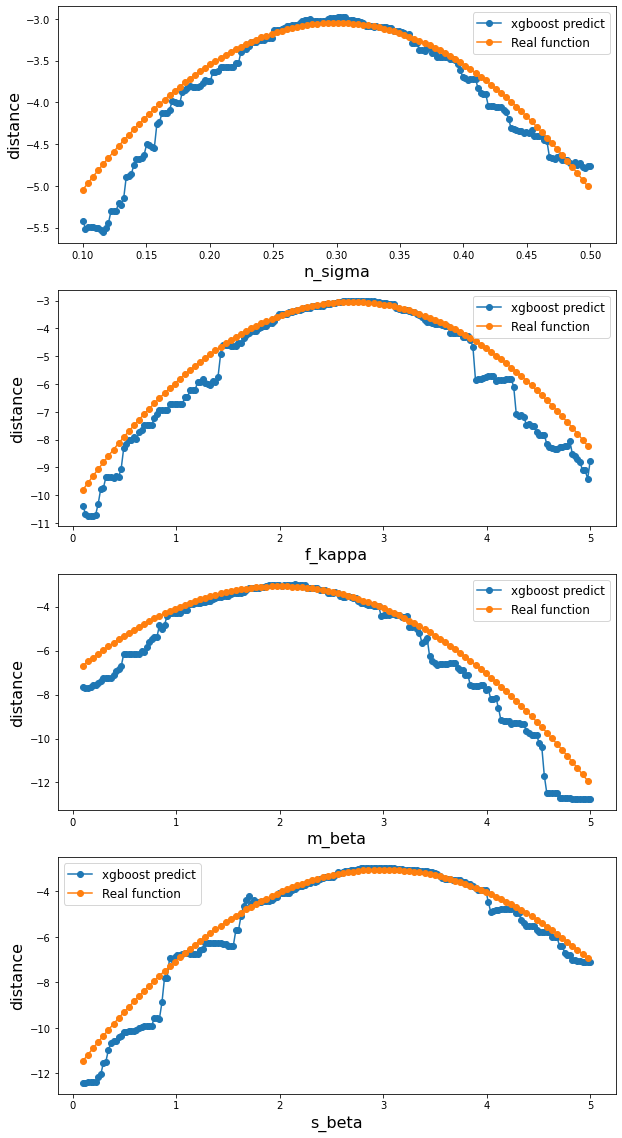

In [8]:
total_y_hat = surrogate_model_XGBoost.predict(total_samples)
print(total_y_hat.shape, total_y_hat.max())
global_ind = total_y_hat.argsort()

# Plot the 1d-slice of the objective function
num = 200
opt = total_samples[global_ind[-1]] # Find the best point
opt_arr = np.array([opt for _ in range(num)])

col = 4
fig, axs = plt.subplots(col, 1, figsize=(10,20))
for i, name in enumerate(['n_sigma', 'f_kappa', 'm_beta', 's_beta']):
    item = params_range[i]
    lb, ub = item[0], item[1]
    print(i, name, item)
    x = opt_arr.copy()
    x[:, i] = np.linspace(lb, ub, num)
    y = surrogate_model_XGBoost.predict(x)
    # y = y.round(4)
    #y1, y2 = y - 1.00 * sigma, y + 1.00 * sigma
    real_x = x[::2, i]
    real_y = [func_opt(xx[0], xx[1], xx[2], xx[3]) for xx in x[::2]]
    axs[i].plot(x[:, i], y, marker='o', label='xgboost predict')
    axs[i].plot(real_x, real_y, marker='o', label='Real function')
    #axs[i].fill_between(x[:, i], y1, y2, alpha=0.3, label='1 std interval')
    axs[i].set_xlabel(name, size=16)
    axs[i].set_ylabel('distance', size=16)
    axs[i].legend(loc='best', prop={'size': 12})

In [10]:
print('predicted best point:', opt)
print('actual best point: ', best)
pred_y_opt = surrogate_model_XGBoost.predict(opt.reshape(1,-1))
simulated_y_opt = func_opt(opt[0], opt[1], opt[2], opt[3])
print('predicted optimal: %.6f; Actual value in the predicted optimal point: %.6f'%(pred_y_opt, simulated_y_opt))

predicted best point: [0.27792969 2.85385742 2.0355957  3.14575195]
actual best point:  [0.3, 2.7, 2, 3]
predicted optimal: -3.007091; Actual value in the predicted optimal point: -3.070538
